![Ryan Klaus](https://images.pexels.com/photos/27429864/pexels-photo-27429864/free-photo-of-mar-ciudad-paisaje-naturaleza.jpeg)

**Competition Description**

This competition is designed for individuals with some experience in R or Python and a basic understanding of machine learning. It is ideal for data science students who have completed an introductory course in machine learning and are seeking to advance their skills before tackling more complex challenges.

**Challenge Overview**

Imagine asking a home buyer to describe their ideal home. They might not mention details such as the height of the basement ceiling or the proximity to an east-west railroad. However, this dataset reveals that many factors beyond just the number of bedrooms or a white picket fence influence home prices.

The dataset for this competition contains 79 explanatory variables that cover nearly every aspect of residential homes in Ames, Iowa. Your task is to predict the final sale price of each home based on these variables.

**Skills to Practice**

- Creative feature engineering
- Advanced regression techniques such as random forest and gradient boosting

**Acknowledgments**

The Ames Housing dataset, compiled by Dean De Cock, is used for educational purposes in data science. It offers a modernized and expanded alternative to the well-known Boston Housing dataset.

**Evaluation**

**Goal**: Predict the sale price for each house. For each ID in the test set, you need to estimate the value of the SalePrice variable.

**Metric**: Submissions are evaluated based on the Root Mean Squared Error (RMSE) between the logarithm of the predicted values and the logarithm of the observed sale prices. This logarithmic transformation ensures that errors in predicting both high and low-priced homes impact the result equally.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot, skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import ElasticNetCV
import tensorflow as tf
import warnings
from IPython.display import display
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor

# Ignorar advertencias
warnings.filterwarnings("ignore")


In [ ]:
import sys
import os
sys.path.append('/kaggle/input/my-py-personal-utils-problemas-de-regresin')

# Importar el módulo de clases y objetos personales especificamente diseñado para manipular datos tabulares con pandas.
import my

In [17]:
def load():
    train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')
    test = train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')
    return train, test
train, test = load()
all_data = pd.concat([train, test], axis = 0)
all_data = all_data.drop("SalePrice", axis=1)
all_data 

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


# 1. EDA (Exploration data analisis)

In [18]:
# llamamos a nuestra clase personalizada EDA para ello
eda = my_EDA()
dirp(eda) # funcion para poder ver clases publicas disponibles


Object my_EDA created

['create_features', 'dependent_var', 'exploration_cat', 'exploration_num', 'get_missing_values', 'hypo_test', 'info', 'plot_high_corr_heatmap', 'plot_missing', 'scarplot_strongs_vars', 'vars_list']


None

<!-- ## 1.2 Análisis de la Variable Dependiente

El objetivo de este análisis es evaluar la distribución de la variable dependiente y determinar la adecuación de su distribución para los supuestos de normalidad requeridos por algunos algoritmos de aprendizaje automático. Para ello, se realizará un examen de la distribución de probabilidad de los datos, así como una evaluación de su sesgo y curtosis utilizando gráficos como el QQ-plot.

Dado que varios algoritmos de aprendizaje automático y técnicas estadísticas suponen la normalidad de los datos, es crucial verificar si la distribución de la variable dependiente se aproxima a una distribución normal. En caso de que se identifique un sesgo significativo o una desviación de la normalidad, se aplicará una transformación para aproximar los datos a una distribución más normalizada. En particular, se utilizará la transformación `np.log1p` para datos positivos, con el objetivo de mitigar el sesgo y ajustar la distribución de manera adecuada. -->

## 1.2 Dependent Variable Analysis

The goal of this analysis is to evaluate the distribution of the dependent variable and determine the adequacy of its distribution for the normality assumptions required by some machine learning algorithms. To this end, we will examine the probability distribution of the data, as well as assess its skewness and kurtosis using plots such as the QQ-plot.

Since several machine learning algorithms and statistical techniques assume normality of the data, it is crucial to check whether the distribution of the dependent variable approximates a normal distribution. If significant skewness or deviation from normality is identified, a transformation will be applied to approximate the data to a more normalized distribution. Specifically, the `np.log1p` transformation will be used for positive data to mitigate skewness and properly adjust the distribution.




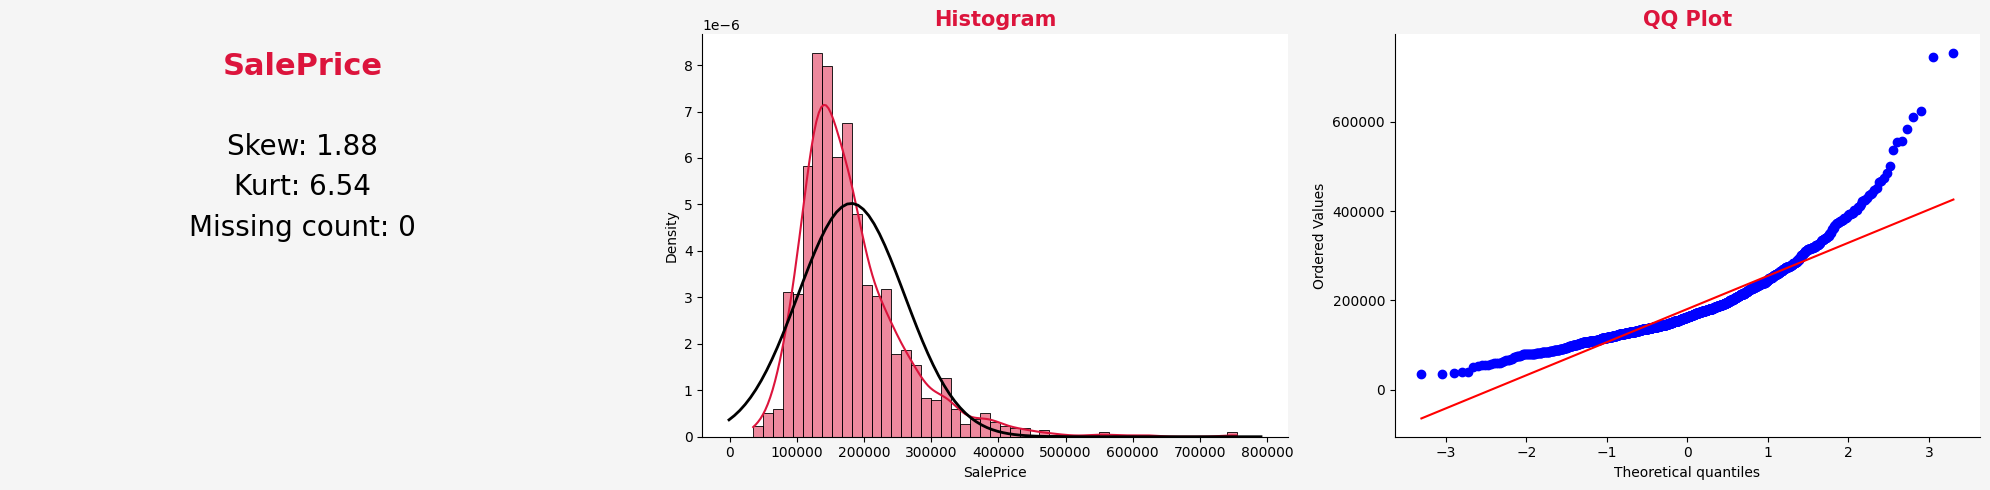

In [21]:
# estudiamos variable dependiente
y = eda.dependent_var(train,'SalePrice')


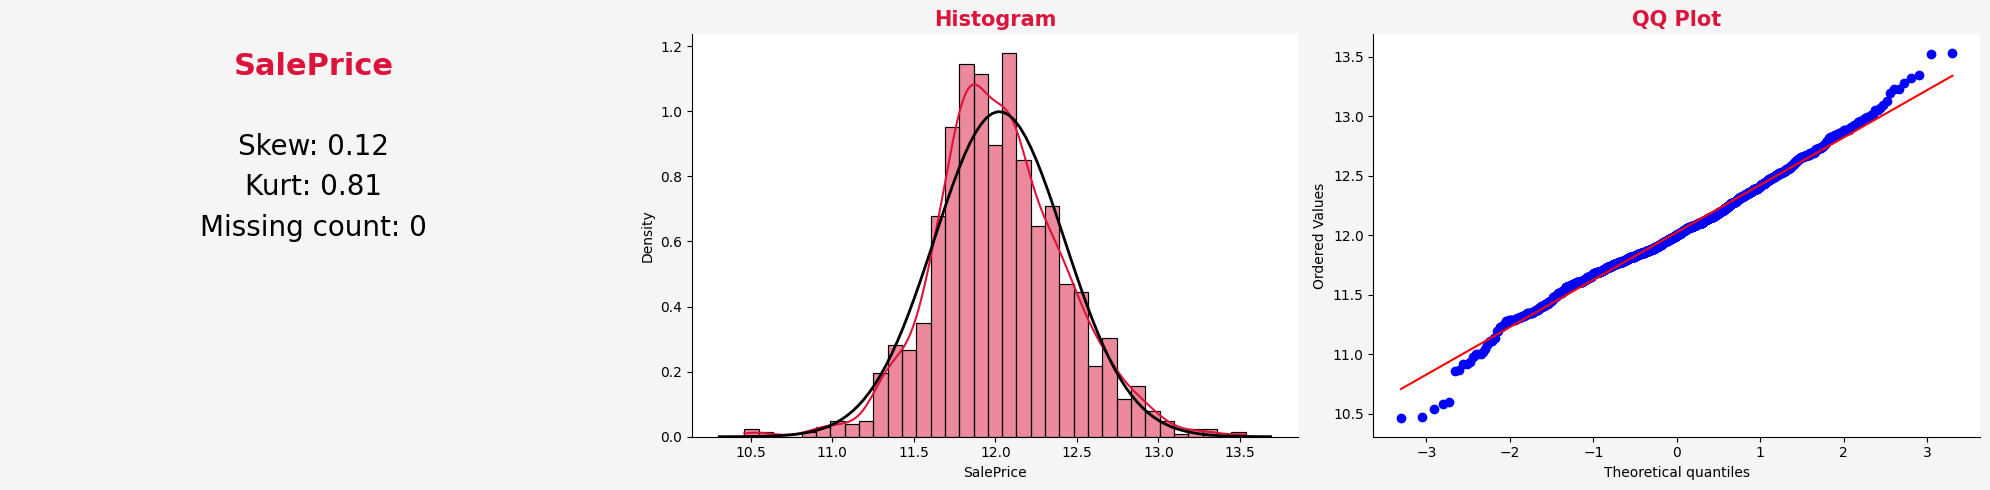

Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [22]:
# vemos que la distribucion de prob. esta sesgada a la derecha. 
# Dado a que tenemos valores positivos, haremos una transformacion matematica
y_log = eda.dependent_var(train, 'SalePrice', log_trans = True)
y_log

In [23]:
dirp(eda)

['create_features', 'dependent_var', 'exploration_cat', 'exploration_num', 'get_missing_values', 'hypo_test', 'info', 'plot_high_corr_heatmap', 'plot_missing', 'scarplot_strongs_vars', 'vars_list']


None


## 1.3 Information About Our Tabular Data

In [24]:
eda.info(all_data)

====> This data contains 2920 rows and 79 columns

FEATURE NAME  DATA FORMAT   NULL VALUES(NUM-PERC)          SEVEN SAMPLES  
------------  -----------   ---------------------          -------------  
PoolQC          object         2906 - 18.559 %     nan,nan,nan,nan,nan,nan,nan,
MiscFeature     object         2812 - 17.959 %     nan,Shed,Shed,nan,nan,Shed,nan,
Alley           object         2738 - 17.486 %     nan,nan,nan,nan,nan,nan,nan,
Fence           object         2358 - 15.059 %     nan,nan,nan,nan,nan,nan,GdWo,
MasVnrType      object         1744 - 11.138 %     nan,nan,nan,nan,nan,BrkFace,BrkFace,
FireplaceQu     object         1380 - 8.813 %      nan,nan,nan,nan,TA,nan,Gd,
LotFrontage     float64        518 - 3.308 %       nan,nan,80.0,53.0,64.0,60.0,nan,
GarageCond      object         162 - 1.035 %       TA,TA,TA,nan,TA,TA,TA,
GarageType      object         162 - 1.035 %       Attchd,BuiltIn,Attchd,Attchd,Detchd,nan,Detchd,
GarageYrBlt     float64        162 - 1.035 %       2

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2920.0,56.897260,42.293325,20.0,20.00,50.0,70.00,190.0
LotFrontage,2402.0,70.049958,24.279694,21.0,59.00,69.0,80.00,313.0
LotArea,2920.0,10516.828082,9979.555080,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,2920.0,6.099315,1.382760,1.0,5.00,6.0,7.00,10.0
OverallCond,2920.0,5.575342,1.112609,1.0,5.00,5.0,6.00,9.0
YearBuilt,2920.0,1971.267808,30.197730,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,2920.0,1984.865753,20.641870,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,2904.0,103.685262,181.035018,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,2920.0,443.639726,456.019958,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,2920.0,46.549315,161.291638,0.0,0.00,0.0,0.00,1474.0


## 1.4 Analysis of Outliers and Missing Values

According to the data description, no outliers were identified in the variable 'YrSold,' such as a value outside the expected range like '2099.' Additionally, it is confirmed that all values in the variables of interest are positive, which is consistent with domain expectations.

Regarding missing values, it is observed that the variable with the highest amount of missing data is 'PoolQC.' This issue must be addressed in the preprocessing phase to ensure the integrity and quality of the data used in subsequent analysis. The strategy for handling these missing values could include imputation based on other features, removing records with missing values, or using specific techniques for handling missing data depending on the problem context.

----

Given the above analysis, I will proceed with handling missing values according to the nature of each variable. Specifically:

Categorical Independent Variables: Missing values in categorical variables will be filled with the value 'None.' This will maintain the integrity of the categorization without introducing arbitrary values that could distort subsequent analyses.

Numerical Independent Variables: Missing values in numerical variables will be replaced with zero. This strategy is justified by the nature of the data and the need to avoid introducing distorting values that could negatively impact the analysis.

Once the imputation process is completed, I will establish a baseline using these preprocessed data. This baseline will serve as a reference for evaluating the impact of the feature engineering techniques implemented subsequently. Evaluating performance from this baseline will effectively measure any improvements or deterioration in predictive models and feature adjustments.

In [28]:
num_vars, cat_vars = eda.vars_list(all_data)


Numerical vars: 
['MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold']

Object vars: 
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 

In [30]:
dirp(eda)
num_missing = eda.get_missing_values(all_data[num_vars],list_mode=True) 
cat_missing = eda.get_missing_values(all_data[cat_vars],list_mode=True) 
cat_missing# mostrar lista de valroes faltantes

['create_features', 'data', 'dependent_var', 'exploration_cat', 'exploration_num', 'get_missing_values', 'hypo_test', 'info', 'missing_values', 'plot_high_corr_heatmap', 'plot_missing', 'scarplot_strongs_vars', 'vars_list']


None

['PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'MasVnrType',
 'FireplaceQu',
 'GarageType',
 'GarageCond',
 'GarageQual',
 'GarageFinish',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtQual',
 'BsmtCond',
 'Electrical']

## 1.5 We Fill Numerical Values with 0 and Categorical Values with 'None' (str type)

In [32]:
# llamo a mi clase personalizada "my_preproc."" para el preprocesamiento 
pre = my_preproc()
dirp(pre)
all_data1 = all_data.copy()
all_data1 = pre.fill(all_data1, num_missing, "zero")
all_data1 = pre.fill(all_data1, cat_missing, "None")
all_data1


pre-processing object is created

['apply_embeddings', 'best_k_plot', 'column_cluster__Kmeans', 'fill', 'get_dummies', 'label_encoder', 'list_skew_num', 'scaler_data_Robust', 'scaler_data_Standard']


None

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal


['create_features', 'data', 'dependent_var', 'exploration_cat', 'exploration_num', 'get_missing_values', 'hypo_test', 'info', 'missing_values', 'plot_high_corr_heatmap', 'plot_missing', 'scarplot_strongs_vars', 'vars_list']


None

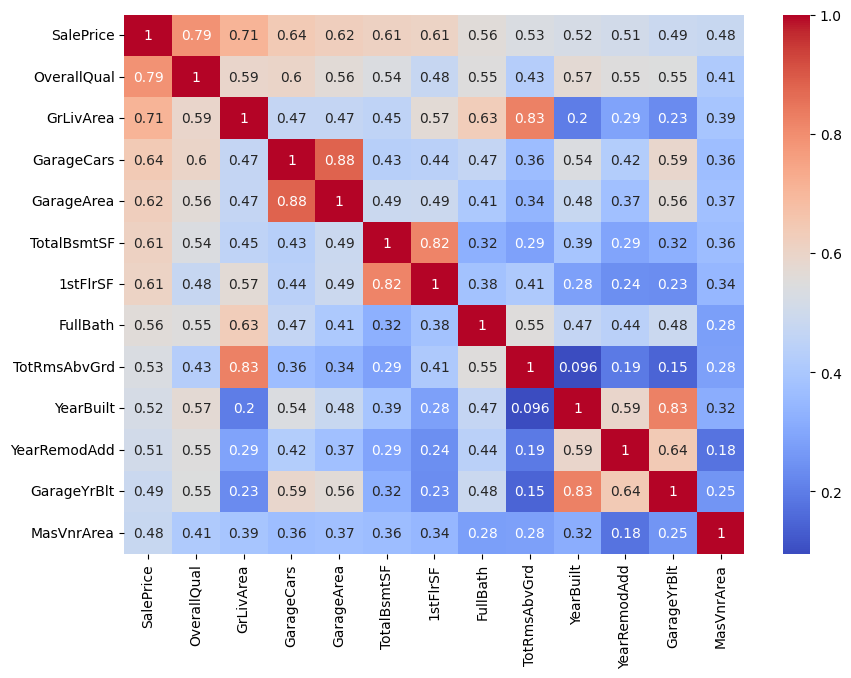

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'MasVnrArea'],
      dtype='object')

In [37]:
dirp(eda)
# evaluamos variables numericas mas correlacionadas con nuestra variable objetivo
corr = eda.plot_high_corr_heatmap(train, 'SalePrice')
corr = corr.drop("SalePrice")
corr

<!-- ## 1.6 Identificación de Valores Atípicos

Con base en el análisis previo, hemos identificado las variables con mayor correlación y, por ende, aquellas que tienen un impacto más significativo en el modelo predictivo. El siguiente paso en el proceso de preprocesamiento es la detección y eliminación de valores atípicos. Estos valores atípicos pueden distorsionar la capacidad predictiva de nuestros modelos de aprendizaje automático (ML) al introducir variabilidad que no refleja adecuadamente la relación subyacente entre las variables.

Para abordar este problema, emplearemos técnicas estadísticamente sencillas pero utiles para identificar estos valores atípicos. La eliminación de dichos valores atípicos se llevará a cabo con el fin de mejorar la precisión y la estabilidad de los modelos predictivos, asegurando que los resultados sean representativos de la tendencia general de los datos. -->

## 1.6 Identification of Outliers

Based on the previous analysis, we have identified the variables with the highest correlation and, consequently, those that have the most significant impact on the predictive model. The next step in the preprocessing process is the detection and removal of outliers. These outliers can distort the predictive capability of our machine learning (ML) models by introducing variability that does not accurately reflect the underlying relationship between the variables.

To address this issue, we will use statistically simple yet effective techniques to identify these outliers. The removal of such outliers will be carried out to improve the accuracy and stability of the predictive models, ensuring that the results are representative of the overall trend in the data.

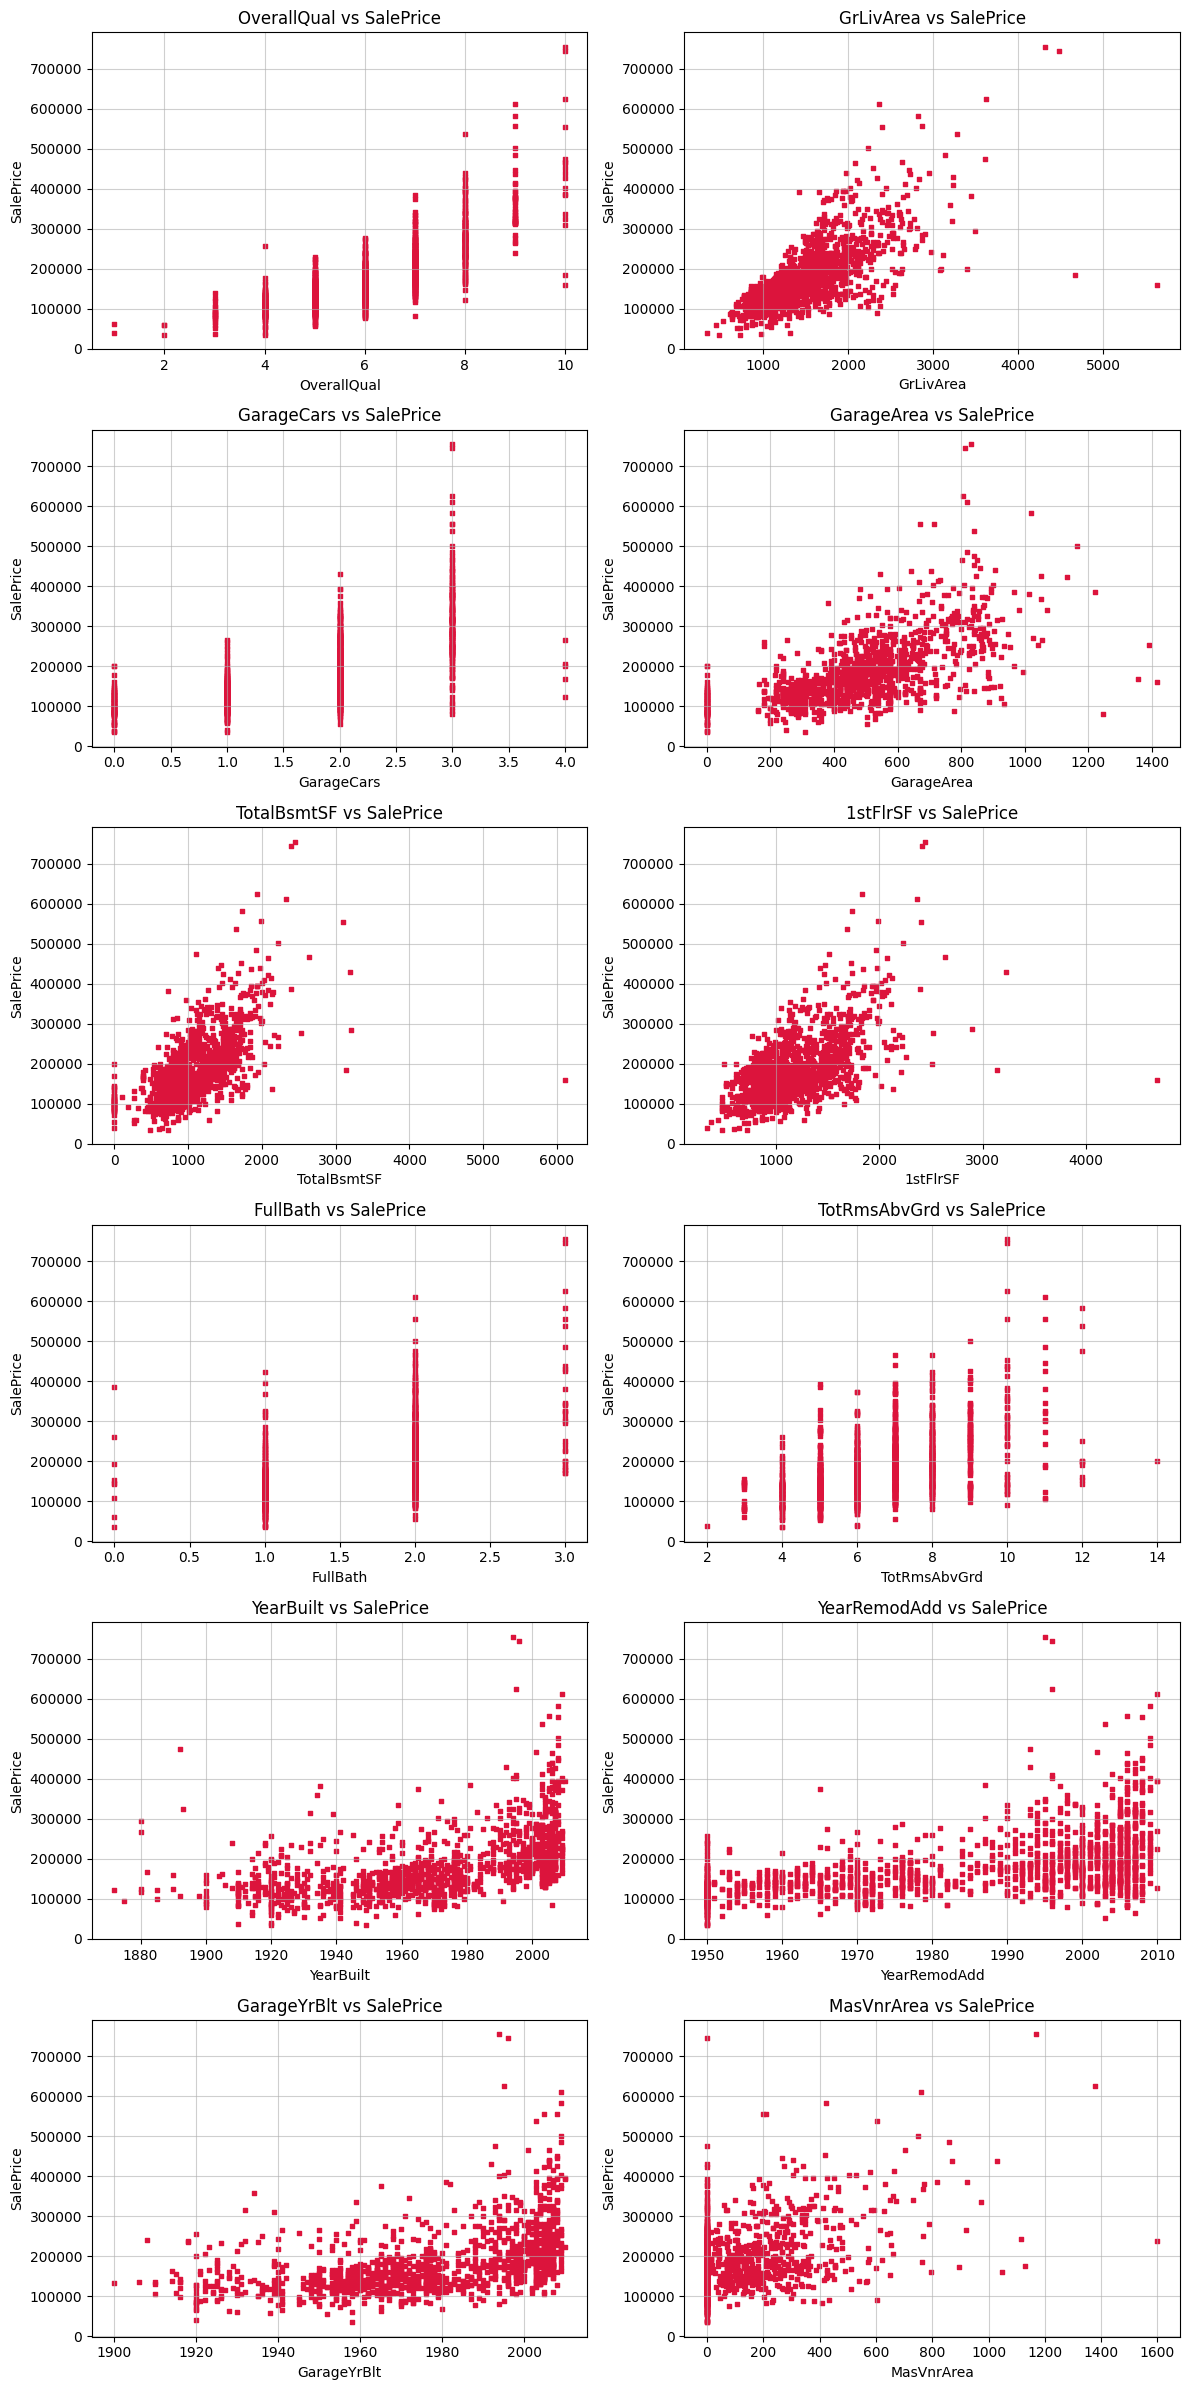

In [38]:
eda.scarplot_strongs_vars(train, 'SalePrice', corr)

## 1.7 We Remove Outliers

<!-- ## 1.7 Eliminamos valores atipicos -->

In [68]:
t_shape = train.shape[0] # filas

all_data2 = all_data1.copy()

all_data2 = all_data2.merge(y_log, on='Id')

def imputed_data():
    train = all_data2.iloc[:t_shape,:]
    test = all_data2.iloc[t_shape:,:]
    return train,test

train,test = imputed_data()


# Eliminamos valores atipicos de nuestro modelo
# Removing outliers / Removiendo valores atipicos 
train = train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 200000)].index)
train = train.drop(train[(train["MasVnrArea"] > 1500) & (train["SalePrice"] < 300000)].index)
train = train.drop(train[(train["1stFlrSF"] > 4000) & (train["SalePrice"] < 200000)].index)
train = train.drop(train[(train["TotalBsmtSF"] > 4000) & (train["SalePrice"] < 200000)].index)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,12.247699
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,12.109016
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,12.317171
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,11.849405
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,12.072547
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,2,2010,WD,Normal,12.254868
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133


In [69]:
all_data2 = all_data2.drop("SalePrice", axis = 1)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal


<!-- ## 1.8 Exploracion y busqueda de variables numericas sesgadas -->

## 1.8 Exploration and Search for Skewed Numerical Variables

['create_features', 'data', 'dependent_var', 'exploration_cat', 'exploration_num', 'get_missing_values', 'hypo_test', 'info', 'missing_values', 'plot_high_corr_heatmap', 'plot_missing', 'scarplot_strongs_vars', 'vars_list']


None

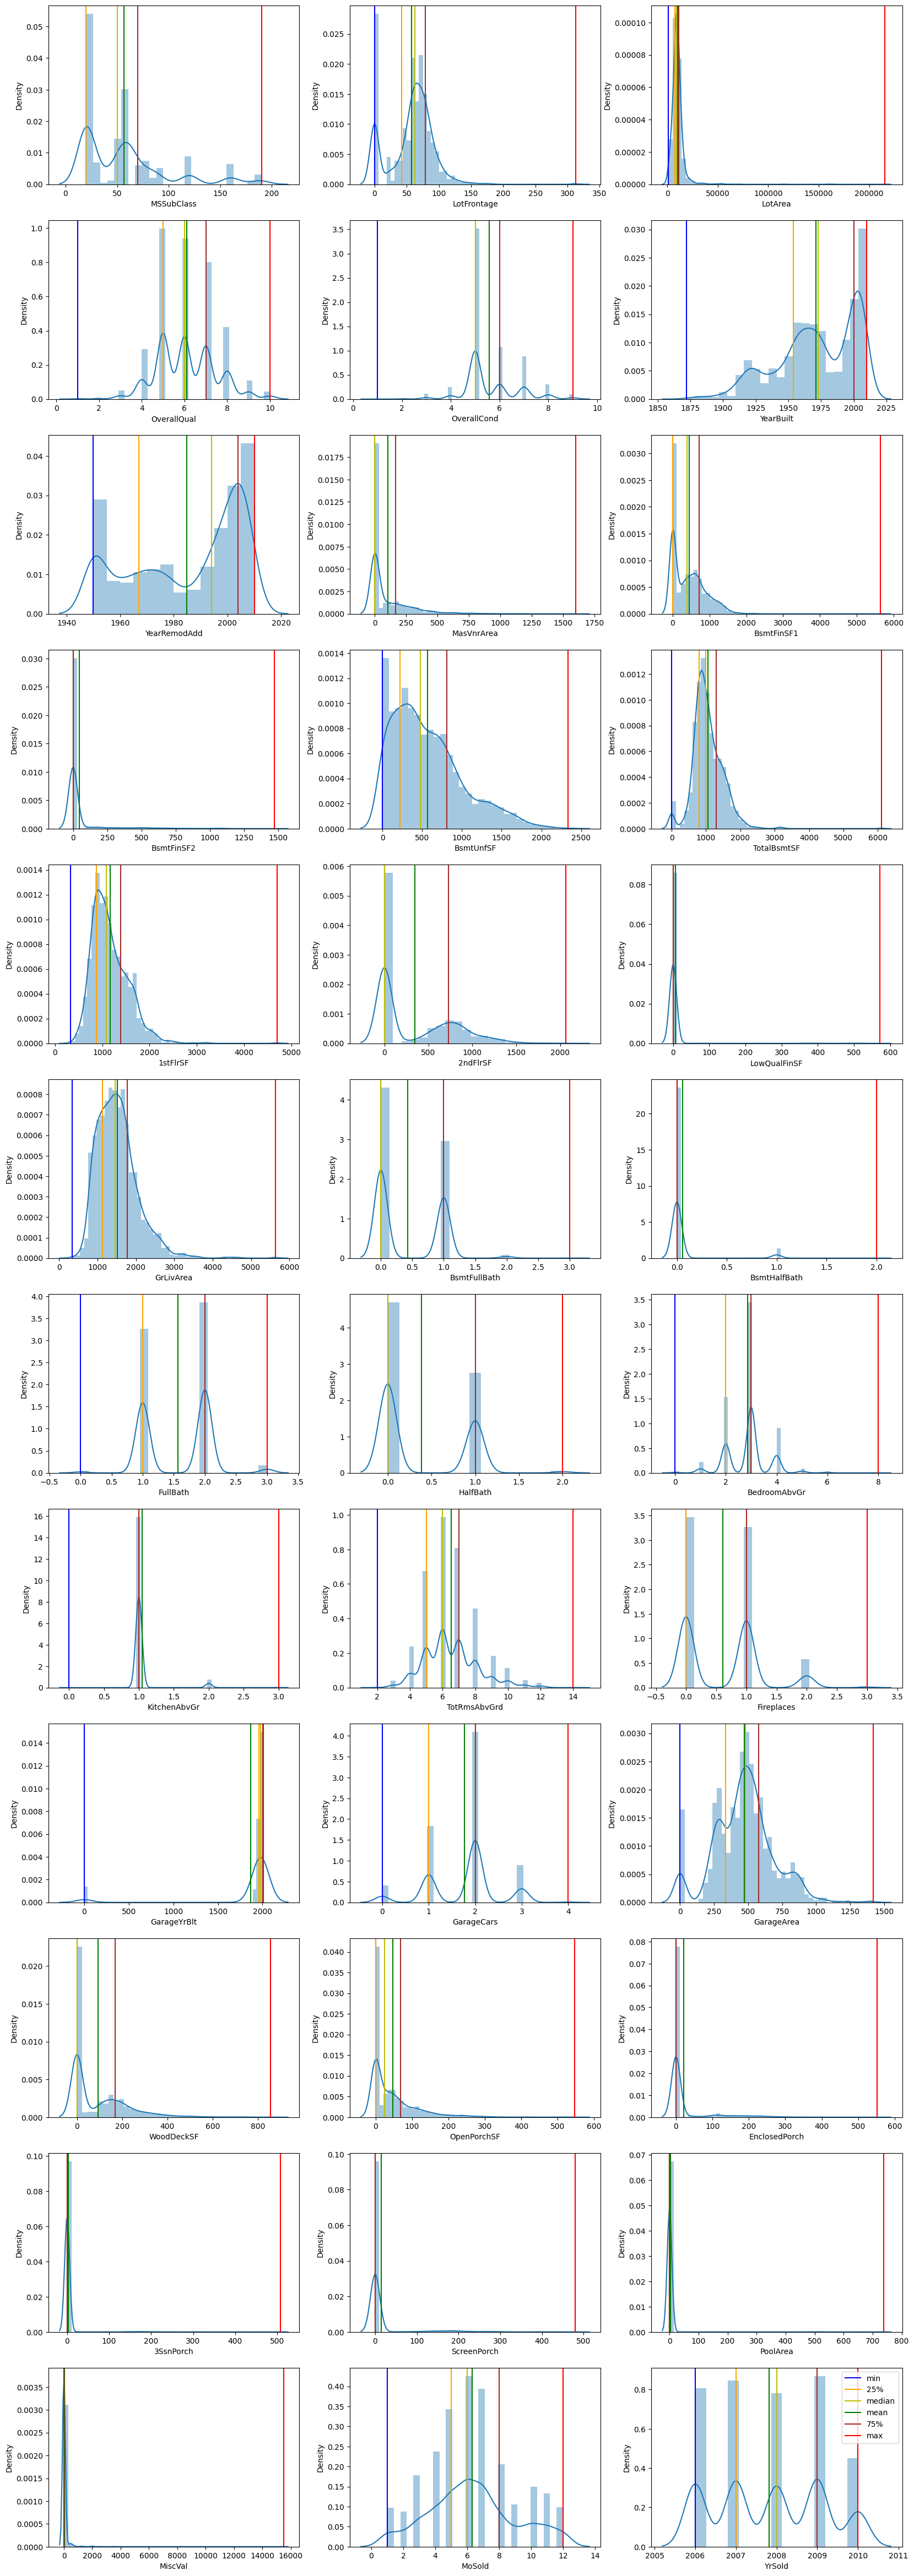

In [71]:
dirp(eda)
eda.exploration_num(all_data2)

# 2. Data Preprocessing - Transformation of Categorical Variables to Numerical

In this phase, our goal is to transform the data into a format suitable for machine learning algorithms.

This process includes converting categorical variables into a representation that models can effectively interpret.

For categorical variables, we will apply encoding techniques to convert non-numeric values into an appropriate numeric form. These techniques may include:

1. One-Hot Encoding: Creating binary variables for each category.

2. Label Encoding: Assigning unique numeric values to each category.

These transformations ensure that categorical variables are correctly interpreted by machine learning algorithms, thereby facilitating modeling and predictive analysis.

## 2.1 Label Encoding (Ordinal)

In this case, we avoid using `LabelEncoder` to preserve the ordinal nature of the data.

In [72]:
all_data2["Street"] = all_data2["Street"].replace({"Grvl": 0, "Pave": 1}) # 1
all_data2["LotShape"] = all_data2["LotShape"].replace({"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0}) # 2
all_data2["Utilities"] = all_data2["Utilities"].replace({"AllPub": 3, "NoSewr": 2, "NoSeWa": 1, "ELO": 0}) # 3
all_data2["LandSlope"] = all_data2["LandSlope"].replace({"Gtl": 2, "Mod": 1, "Sev": 0}) # 4
all_data2["ExterQual"] = all_data2["ExterQual"].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}) # 5
all_data2["ExterCond"] = all_data2["ExterCond"].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}) # 6
all_data2["BsmtQual"] = all_data2["BsmtQual"].replace({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoBasement": 0}) # 7
all_data2["BsmtCond"] = all_data2["BsmtCond"].replace({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoBasement": 0}) # 8
all_data2["BsmtExposure"] = all_data2["BsmtExposure"].replace({"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NoBasement": 0}) # 9
all_data2["BsmtFinType1"] = all_data2["BsmtFinType1"].replace({"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NoBasement": 0}) # 10
all_data2["BsmtFinType2"] = all_data2["BsmtFinType2"].replace({"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NoBasement": 0}) # 11
all_data2["HeatingQC"] = all_data2["HeatingQC"].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}) # 12
all_data2["CentralAir"] = all_data2["CentralAir"].replace({"Y": 1, "N": 0}) # 13
all_data2["Electrical"] = all_data2["Electrical"].replace({"SBrkr": 3, "FuseA": 2, "FuseF": 1, "FuseP": 0, "Mix": 2}) # 14
all_data2["KitchenQual"] = all_data2["KitchenQual"].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}) # 15
all_data2["Functional"] = all_data2["Functional"].replace({"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0}) # 16
all_data2["FireplaceQu"] = all_data2["FireplaceQu"].replace({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoFireplace": 0}) # 17
all_data2["GarageFinish"] = all_data2["GarageFinish"].replace({"Fin": 3, "RFn": 2, "Unf": 1, "NoGarage": 0}) # 18
all_data2["GarageQual"] = all_data2["GarageQual"].replace({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoGarage": 0}) # 19
all_data2["GarageCond"] = all_data2["GarageCond"].replace({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoGarage": 0}) # 20
all_data2["PavedDrive"] = all_data2["PavedDrive"].replace({"Y": 2, "P": 1, "N": 0}) # 21
all_data2["PoolQC"] = all_data2["PoolQC"].replace({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NoPool': 0}) # 22
all_data2["Fence"] = all_data2["Fence"].replace({"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "NoFence": 0}) # 23



## 2.2 OneHot Encoding (Nomial)¶

In [73]:
all_data2['MoSold'] = all_data2['MoSold'].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
all_data2['YrSold'] = all_data2['YrSold'].astype('str')
all_data3 = pd.get_dummies(all_data2)

In [74]:
all_data3

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,1,3,3,2,7,5,2003,...,False,False,False,True,False,False,False,False,True,False
2,20,80.0,9600,1,3,3,2,6,8,1976,...,False,False,False,True,False,False,False,False,True,False
3,60,68.0,11250,1,2,3,2,7,5,2001,...,False,False,False,True,False,False,False,False,True,False
4,70,60.0,9550,1,2,3,2,7,5,1915,...,False,False,False,True,True,False,False,False,False,False
5,60,84.0,14260,1,2,3,2,8,5,2000,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,1,3,3,2,6,5,1999,...,False,False,False,True,False,False,False,False,True,False
1457,20,85.0,13175,1,3,3,2,6,6,1978,...,False,False,False,True,False,False,False,False,True,False
1458,70,66.0,9042,1,3,3,2,7,9,1941,...,False,False,False,True,False,False,False,False,True,False


## 2.3 Separamos train y test de all_data

In [81]:

def load_data3():
    train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col = 'Id')
    train_shape = train.shape[0]
    train = all_data3.iloc[:train_shape,:]
    test = all_data3.iloc[train_shape:,:]
    return train, test

train,test =  load_data3()
train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,1,3,3,2,7,5,2003,...,False,False,False,True,False,False,False,False,True,False
2,20,80.0,9600,1,3,3,2,6,8,1976,...,False,False,False,True,False,False,False,False,True,False
3,60,68.0,11250,1,2,3,2,7,5,2001,...,False,False,False,True,False,False,False,False,True,False
4,70,60.0,9550,1,2,3,2,7,5,1915,...,False,False,False,True,True,False,False,False,False,False
5,60,84.0,14260,1,2,3,2,8,5,2000,...,False,False,False,True,False,False,False,False,True,False


In [96]:
y_log

Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [105]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor



ml = my_ML()
dirp(ml)

# Ahora puedes usar LinearRegression sin problemas
ml.cross_validate_kfold_v1(train, y_log, model=XGBRegressor(), log=True)



models ML is created

['Auto_ElasticNetCV', 'Auto_xgbrCV', 'cross_validate_kfold_v1', 'eval_graf_errors', 'obtener_datos_reg', 'plot_error_distribution', 'r2_cv_test', 'r2_cv_train']


None

---------------------------------------------

Métricas sin transformación matemática (exp)
---------------------------------------------
Mean across folds (MSE): 0.0216
Standard Deviation of (MSE): 0.0048

Mean across folds (RMSE): 0.1460
Standard Deviation of (RMSE): 0.0162

Mean across folds (MAE): 0.0982
Standard Deviation of (MAE): 0.0076

Mean across folds (R²): 0.8627
Standard Deviation of (R²): 0.0368

---------------------------------------------

Métricas en términos reales de nuestra variable objetivo
---------------------------------------------
Mean across folds (MSE): 1108027593.7513
Standard Deviation of (MSE): 446826785.2912

Mean across folds (RMSE): 32636.4011
Standard Deviation of (RMSE): 6549.2684

Mean across folds (MAE): 18096.5903
Standard Deviation of (MAE): 1406.9934

Mean across folds (R²): 0.8188
Standard Deviation of (R²): 0.0840


<!-- # Ingeniería de Características

En esta fase, desarrollaremos nuevas características a partir de las variables numéricas más significativas. Específicamente, aplicaremos transformaciones polinomiales, elevando estas variables al cuadrado y al cubo. El objetivo de estas transformaciones es captar patrones no lineales y relaciones más complejas que podrían no ser evidentes con las características originales. Estas nuevas características permitirán que los modelos de aprendizaje automático exploren mejor las interacciones no lineales dentro de los datos. -->

# Feature Engineering

In this phase, we will develop new features from the most significant numerical variables. Specifically, we will apply polynomial transformations by squaring and cubing these variables. The goal of these transformations is to capture nonlinear patterns and more complex relationships that may not be evident with the original features. These new features will enable machine learning models to better explore nonlinear interactions within the data.

In [110]:
corr = list(corr)
corr

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MasVnrArea']

In [111]:
dirp(pre)

def add_mathematical_transformed_cols(df, columns):
    """
    Añade nuevas características al DataFrame para cada columna en 'columns'.
    Las nuevas características son: la columna al cuadrado, al cubo, y su raíz cuadrada.
    
    Parámetros:
    - df: pd.DataFrame, DataFrame de entrada.
    - columns: list de str, lista de nombres de columnas a transformar.
    
    Retorna:
    - pd.DataFrame con las nuevas características añadidas.
    """
    df_transformed = df.copy()  # Crear una copia del DataFrame original
    
    for col in columns:
        if col in df.columns:
            # Crear nuevas características
            df_transformed[col + '_squared'] = df[col] ** 2
            df_transformed[col + '_cubed'] = df[col] ** 3
            df_transformed[col + '_sqrt'] = np.sqrt(df[col].clip(lower=0))  # Aplicar sqrt solo a valores no negativos
    
    return df_transformed



train = add_mathematical_transformed_cols(train, corr)
test = add_mathematical_transformed_cols(test, corr)

train.head()


['apply_embeddings', 'best_k_plot', 'column_cluster__Kmeans', 'fill', 'get_dummies', 'label_encoder', 'list_skew_num', 'scaler_data_Robust', 'scaler_data_Standard']


None

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,YearBuilt_sqrt,YearRemodAdd_squared,YearRemodAdd_cubed,YearRemodAdd_sqrt,GarageYrBlt_squared,GarageYrBlt_cubed,GarageYrBlt_sqrt,MasVnrArea_squared,MasVnrArea_cubed,MasVnrArea_sqrt
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,1,3,3,2,7,5,2003,...,44.754888,4012009,8036054027,44.754888,4012009.0,8.036054e+09,44.754888,38416.0,7529536.0,14.000000
2,20,80.0,9600,1,3,3,2,6,8,1976,...,44.452222,3904576,7715442176,44.452222,3904576.0,7.715442e+09,44.452222,0.0,0.0,0.000000
3,60,68.0,11250,1,2,3,2,7,5,2001,...,44.732538,4008004,8024024008,44.743715,4004001.0,8.012006e+09,44.732538,26244.0,4251528.0,12.727922
4,70,60.0,9550,1,2,3,2,7,5,1915,...,43.760713,3880900,7645373000,44.384682,3992004.0,7.976024e+09,44.698993,0.0,0.0,0.000000
5,60,84.0,14260,1,2,3,2,8,5,2000,...,44.721360,4000000,8000000000,44.721360,4000000.0,8.000000e+09,44.721360,122500.0,42875000.0,18.708287


In [112]:
# evaluamos si esto es fructifero, a traves de validacion crusada

ml.cross_validate_kfold_v1(train, y_log, model=XGBRegressor(), log=True) 
# conclusion no cambio en practicamente en nada nuestros score 

---------------------------------------------

Métricas sin transformación matemática (exp)
---------------------------------------------
Mean across folds (MSE): 0.0216
Standard Deviation of (MSE): 0.0048

Mean across folds (RMSE): 0.1460
Standard Deviation of (RMSE): 0.0162

Mean across folds (MAE): 0.0982
Standard Deviation of (MAE): 0.0076

Mean across folds (R²): 0.8627
Standard Deviation of (R²): 0.0368

---------------------------------------------

Métricas en términos reales de nuestra variable objetivo
---------------------------------------------
Mean across folds (MSE): 1108027593.7513
Standard Deviation of (MSE): 446826785.2912

Mean across folds (RMSE): 32636.4011
Standard Deviation of (RMSE): 6549.2684

Mean across folds (MAE): 18096.5903
Standard Deviation of (MAE): 1406.9934

Mean across folds (R²): 0.8188
Standard Deviation of (R²): 0.0840


In [ ]:
# Creamos mas caracteristicas

def more_features(df):

    # Área del Primer Piso a la Superficie Total
    df['1stFlrToGrLivArea'] = df['1stFlrSF'] / df['GrLivArea']

    # Área del Sótano a la Superficie Total
    df['BsmtToGrLivArea'] = df['TotalBsmtSF'] / df['GrLivArea']

    # Edad de la Vivienda al Momento de la Venta
    df['AgeAtSale'] = df['YrSold'] - df['YearBuilt']

    # Años Desde la Última Remodelación
    df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']

    # Edad del Garaje al Momento de la Venta
    df['GarageAgeAtSale'] = df['YrSold'] - df['GarageYrBlt']

    # Número de Baños por Número de Habitaciones
    # Asumimos que HalfBath está en términos de 0.5 baños, ajusta si es diferente
    df['BathsPerRoom'] = (df['FullBath'] + df['HalfBath']) / df['TotRmsAbvGrd']

    # Número de Habitaciones por Área Total de Vivienda
    df['RmsPerSqft'] = df['TotRmsAbvGrd'] / df['GrLivArea']

    # Calidad General Dividida por el Área Total de Vivienda
    df['QualToGrLivArea'] = df['OverallQual'] / df['GrLivArea']

    # Área del MasVnr a la Superficie Total
    df['MasVnrToGrLivArea'] = df['MasVnrArea'] / df['GrLivArea']

    # Proporción del Área del Primer Piso al Área del Segundo Piso
    df['1stFlrTo2ndFlr'] = df['1stFlrSF'] / df['2ndFlrSF'].replace(0, pd.NA)

    # Proporción de Espacio Total del Sótano a Espacio Total en la Vivienda
    df['BsmtToTotal'] = df['TotalBsmtSF'] / (df['GrLivArea'] + df['TotalBsmtSF'])

    # Proporción del Año de Remodelación al Año de Construcción
    df['RemodToBuild'] = df['YearRemodAdd'] / df['YearBuilt']
    return df

train = more_features(train)
test = more_features(test)
train.head()

In [122]:
def base():
    ml.cross_validate_kfold_v1(train, y_log, model=XGBRegressor(), log=True) 
    
base()

---------------------------------------------

Métricas sin transformación matemática (exp)
---------------------------------------------
Mean across folds (MSE): 0.0217
Standard Deviation of (MSE): 0.0056

Mean across folds (RMSE): 0.1462
Standard Deviation of (RMSE): 0.0190

Mean across folds (MAE): 0.0980
Standard Deviation of (MAE): 0.0083

Mean across folds (R²): 0.8620
Standard Deviation of (R²): 0.0406

---------------------------------------------

Métricas en términos reales de nuestra variable objetivo
---------------------------------------------
Mean across folds (MSE): 1150542160.2739
Standard Deviation of (MSE): 544419555.5386

Mean across folds (RMSE): 33062.1956
Standard Deviation of (RMSE): 7578.4817

Mean across folds (MAE): 18060.2834
Standard Deviation of (MAE): 1579.8063

Mean across folds (R²): 0.8115
Standard Deviation of (R²): 0.1042


In [124]:
# vamos a normalizar las variables numericas sesgadas con robust scaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Normalizar las variables numéricas sesgadas con RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(train)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)

In [128]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Construyendo Pipeline
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'LGBMRegressor': LGBMRegressor(verbose=-1),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)
}

params = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.001, 0.01, 0.1]},
    'ElasticNet': {'model__alpha': [0.001, 0.01, 0.1], 'model__l1_ratio': [0.2, 0.5, 0.8]},
    'SVR': {'model__C': [0.1, 1, 10], 'model__epsilon': [0.1, 0.2, 0.5], 'model__kernel': ['linear', 'rbf']},
    'RandomForestRegressor': {'model__n_estimators': [10, 50, 100]},
    'XGBRegressor': {'model__learning_rate': [0.1, 0.5], 'model__max_depth': [3, 5, 7]},
    'LGBMRegressor': {'model__learning_rate': [0.1, 0.5], 'model__num_leaves': [31, 50, 100]},
    'CatBoostRegressor': {'model__learning_rate': [0.01, 0.1, 0.5], 'model__depth': [4, 6, 8]}
}

results = []

In [129]:
# Define the RMSE function
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [134]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import math

for name, model in models.items():
    pipeline = Pipeline([
        ('model', model)
    ])
    if name in params:
        grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring=rmse_scorer)
    else:
        grid_search = GridSearchCV(pipeline, {}, cv=5, scoring=rmse_scorer)
        
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    r2 = grid_search.best_estimator_.score(X_test, y_test)
    rmse_val = rmse(y_test, y_pred)
    results.append({
        'Model': name,
        'R-Squared Score': r2,
        'RMSE Score': rmse_val,
        'Best Parameters': grid_search.best_params_
    })

results_df = pd.DataFrame(results)


In [142]:
results_df

,Model,R-Squared Score,RMSE Score,Best Parameters
1,Ridge,0.874931,30972.857875,{'model__alpha': 10.0}
2,Lasso,0.827056,36421.633845,{'model__alpha': 0.1}
3,ElasticNet,0.874537,31021.633405,"{'model__alpha': 0.01, 'model__l1_ratio': 0.2}"
4,SVR,0.734722,45108.435317,"{'model__C': 10, 'model__epsilon': 0.1, 'model..."
5,RandomForestRegressor,0.891672,28825.553047,{'model__n_estimators': 100}
6,XGBRegressor,0.908907,26433.207992,"{'model__learning_rate': 0.1, 'model__max_dept..."
7,LGBMRegressor,0.891219,28885.688728,"{'model__learning_rate': 0.1, 'model__num_leav..."
8,CatBoostRegressor,0.901684,27461.104400,"{'model__depth': 6, 'model__learning_rate': 0.1}"


In [143]:
# Basados en árboles de decisión y boosting de gradiente:

# CatBoostRegressor: Un modelo de boosting basado en árboles de decisión, conocido por su buen rendimiento en problemas de regresión.
catboost = CatBoostRegressor(learning_rate=0.1, depth=6, verbose=0)
catboost.fit(X_scaled, y_log)
# Realizar predicciones (descomentar y ajustar si es necesario)
# pred = catboost.predict(X_test)
# Aplicar la inversa de la transformación logarítmica si se usó (descomentar si es necesario)
# pred = np.exp(pred)

# XGBRegressor: Un modelo de boosting basado en árboles de decisión, popular por su capacidad para manejar datos grandes y complejos.
xgb = XGBRegressor(learning_rate=0.1, max_depth=6)
xgb.fit(X_scaled, y_log)
# Realizar predicciones (descomentar y ajustar si es necesario)
# pred = xgb.predict(X_test)
# Aplicar la inversa de la transformación logarítmica si se usó (descomentar si es necesario)
# pred = np.exp(pred)



# Basados en regresión lineal:
# Ridge Regression: Una regresión lineal con regularización L2 para reducir el sobreajuste.
ridge = Ridge(alpha=10.0)
ridge.fit(X_scaled, y_log)

# ElasticNet: Una combinación de regresión L1 y L2 que permite seleccionar características y reducir el sobreajuste.
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.2)
elasticnet.fit(X_scaled, y_log)



# Basados en máquinas de vectores de soporte (SVR):
# SVR (Support Vector Regression): Un modelo de regresión basado en el principio de margen máximo, adecuado para problemas de regresión complejos.

# Comentario final:
# Los modelos basados en árboles de decisión y boosting de gradiente (CatBoostRegressor y XGBRegressor) son adecuados para problemas donde los datos pueden tener relaciones no lineales y complejas.
# Los modelos de regresión lineal (Ridge y ElasticNet) se utilizan cuando se desea aplicar una penalización para manejar el sobreajuste y mejorar la generalización.
# SVR es útil para problemas de regresión donde las relaciones entre variables pueden ser no lineales y es necesario encontrar una función de regresión que minimice los errores dentro de un margen.



SVR(C=10)

In [164]:
test

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,YearBuilt_sqrt,YearRemodAdd_squared,YearRemodAdd_cubed,YearRemodAdd_sqrt,GarageYrBlt_squared,GarageYrBlt_cubed,GarageYrBlt_sqrt,MasVnrArea_squared,MasVnrArea_cubed,MasVnrArea_sqrt
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,1,3,3,2,7,5,2003,...,44.754888,4012009,8036054027,44.754888,4012009.0,8.036054e+09,44.754888,38416.0,7529536.0,14.000000
2,20,80.0,9600,1,3,3,2,6,8,1976,...,44.452222,3904576,7715442176,44.452222,3904576.0,7.715442e+09,44.452222,0.0,0.0,0.000000
3,60,68.0,11250,1,2,3,2,7,5,2001,...,44.732538,4008004,8024024008,44.743715,4004001.0,8.012006e+09,44.732538,26244.0,4251528.0,12.727922
4,70,60.0,9550,1,2,3,2,7,5,1915,...,43.760713,3880900,7645373000,44.384682,3992004.0,7.976024e+09,44.698993,0.0,0.0,0.000000
5,60,84.0,14260,1,2,3,2,8,5,2000,...,44.721360,4000000,8000000000,44.721360,4000000.0,8.000000e+09,44.721360,122500.0,42875000.0,18.708287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,1,3,3,2,6,5,1999,...,44.710178,4000000,8000000000,44.721360,3996001.0,7.988006e+09,44.710178,0.0,0.0,0.000000
1457,20,85.0,13175,1,3,3,2,6,6,1978,...,44.474712,3952144,7856862272,44.586994,3912484.0,7.738893e+09,44.474712,14161.0,1685159.0,10.908712
1458,70,66.0,9042,1,3,3,2,7,9,1941,...,44.056782,4024036,8072216216,44.788391,3767481.0,7.312681e+09,44.056782,0.0,0.0,0.000000


In [ ]:
def pred_log(model_after_fith):
    predictions = model_after_fith.predict(test)
    predictions_final = np.expm1(predictions2)
    return predictions_final

pf1 = pred_log(catboost)
pf2 = pred_log(ridge)
pf3 = pred_log(xgb)
pf4 = pred_log(elasticnet)



we perform a weighted average of the predictions to diversify and enhance the robustness of our model's output. This approach helps in combining the strengths of different predictive models, thereby improving overall accuracy and reducing the impact of individual model biases or errors.

In [ ]:
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

# Submission
submission["SalePrice"] = pf1.astype('float64') * 0.2 + pf2.astype('float64') * 0.2 + pf3.astype('float64') * 0.4 +pf3.astype('float64') * 0.2

low = submission['SalePrice'].quantile(0.01)
high = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = np.where(submission['SalePrice'] < low, low, submission['SalePrice'])
submission['SalePrice'] = np.where(submission['SalePrice'] > high, high, submission['SalePrice'])

submission.to_csv("submission.csv", index=False)

Kne1a: We ended up in the top 5% of the [competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) in data science (221 out of 4734) as of August 22, 2024, with an RMSE of 0.1394.